# Measure the Difference between Preprint-Published similarity and Published Articles

This notebook measures the time delay that results from the peer review process. Two plots are generated: one that depict the average publication time delay as changes are demanded from the peer review process and the other that depicts the added time delay as preprints have to undergo multiple versions to be published.

In [1]:
from datetime import timedelta
import random
from pathlib import Path

import numpy as np
import pandas as pd
import plotnine as p9
import requests
from scipy.spatial.distance import cdist
from scipy.stats import linregress
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
import tqdm

from mizani.breaks import date_breaks
from mizani.formatters import timedelta_format, log_format

# Gather Preprint-Published Pairs

## bioRxiv Document Embeddings

In [2]:
url = "https://api.biorxiv.org/pub/2000-01-01/3000-01-01/"

In [3]:
already_downloaded = Path("output/biorxiv_published_dates.tsv").exists()
if not already_downloaded:
    collection = []
    page_size = 100
    total = 44397
    for i in tqdm.tqdm(range(0, total, page_size), total=total / page_size):
        collection += requests.get(url + str(i)).json()["collection"]
    published_dates = pd.DataFrame(collection)
    published_dates.to_csv("output/biorxiv_published_dates.tsv", sep="\t", index=False)
else:
    published_dates = pd.read_csv("output/biorxiv_published_dates.tsv", sep="\t")

print(published_dates.shape)
published_dates.head()

(44397, 7)


,biorxiv_doi,published_doi,preprint_title,preprint_category,preprint_date,published_date,published_citation_count
0,10.1101/001081,10.1093/bioinformatics/btu121,PyRAD: assembly of de novo RADseq loci for phy...,Bioinformatics,2013-12-03,2014-03-05,184
1,10.1101/001297,10.1371/journal.pone.0085203,Aerodynamic characteristics of a feathered din...,Biophysics,2013-12-10,2014-01-15,11
2,10.1101/000422,10.3389/fgene.2014.00013,On the optimal trimming of high-throughput mRN...,Bioinformatics,2013-11-14,2014-01-31,44
3,10.1101/001396,10.1162/NECO_a_00568,Parametric inference in the large data limit u...,Biophysics,2013-12-13,2014-03-10,4
4,10.1101/002980,10.1016/j.bpj.2014.01.012,Genetic drift suppresses bacterial conjugation...,Biophysics,2014-02-24,2014-02-18,10


In [4]:
biorxiv_journal_df = (
    pd.read_csv("../journal_tracker/output/mapped_published_doi.tsv", sep="\t")
    .groupby("preprint_doi")
    .agg(
        {
            "document": "first",
            "category": "first",
            "preprint_doi": "count",
            "published_doi": "first",
            "pmcid": "first",
            "pmcoa": "first",
        }
    )
    .rename(index=str, columns={"preprint_doi": "version_count"})
    .reset_index()
)
print(biorxiv_journal_df.shape)
biorxiv_journal_df.head()

(71115, 7)


,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True
1,10.1101/000042,000042_v1.xml,genomics,3,10.1038/nrg3723,PMC4151119,False
2,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True
3,10.1101/000091,000091_v1.xml,synthetic biology,1,NaN,NaN,False
4,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True


In [5]:
biorxiv_embed_df = pd.read_csv(
    Path("../word_vector_experiment/output/")
    / "word2vec_output/"
    / "biorxiv_all_articles_300_fixed.tsv.xz",
    sep="\t",
)
biorxiv_embed_df = biorxiv_embed_df.dropna()
print(biorxiv_embed_df.shape)
biorxiv_embed_df.head()

(98007, 301)


,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,0.063813,0.012187,-0.156229,-0.158987,0.165480,-0.346612,0.001741,-0.107139,0.684055,...,-0.140772,-0.143405,-0.081427,-0.248220,-0.771470,-0.235455,0.547801,0.859663,-0.063151,0.012667
1,775270_v1.xml,-0.201064,0.011870,-0.354809,-0.150633,0.095305,-0.507254,-0.339986,0.303313,0.944561,...,-0.115199,-0.259798,0.272955,-0.346138,-0.844158,-0.596267,0.121678,0.959160,-0.747369,-0.073314
2,242404_v1.xml,-0.204741,-0.107589,-0.062853,0.140793,0.066307,-0.463290,-0.106492,-0.040269,0.557687,...,-0.229839,-0.325765,-0.064586,-0.300529,-0.707948,-0.479390,0.381809,0.968333,-0.402499,-0.109250
3,872994_v1.xml,-0.256990,-0.055972,-0.300816,0.495731,0.290070,-0.310817,-0.481578,-0.161373,0.483896,...,0.148916,-0.217426,0.195183,-0.069086,-0.545689,-0.517949,0.265230,0.645038,-0.843499,-0.142928
4,080853_v2.xml,0.167641,0.046808,-0.709753,0.232242,-0.139213,-0.319284,-0.314807,0.310180,0.317704,...,0.540693,0.264286,0.256323,0.137184,-0.754344,-0.145583,0.032544,0.507430,-0.374320,0.473060


## PMC Article Embeddings

In [6]:
pmc_articles_df = pd.read_csv(
    Path("../../pmc/exploratory_data_analysis/")
    / "output/pubmed_central_journal_paper_map.tsv.xz",
    sep="\t",
).query("article_type=='research-article'")
print(pmc_articles_df.shape)
pmc_articles_df.head()

(1977651, 4)


,journal,article_type,doi,pmcid
0,Environ_Health,research-article,10.1186/1476-069X-5-22,PMC1552054
1,Environ_Health,research-article,10.1186/1476-069X-4-12,PMC1226148
3,Environ_Health,research-article,10.1186/s12940-017-0316-3,PMC5635510
4,Environ_Health,research-article,10.1186/1476-069X-10-46,PMC3125232
5,Environ_Health,research-article,10.1186/1476-069X-11-91,PMC3533997


In [7]:
pmc_embed_df = pd.read_csv(
    Path("../../pmc/word_vector_experiment/output")
    / Path("pmc_document_vectors_300_replace.tsv.xz"),
    sep="\t",
)
pmc_embed_df.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,PMC1552054,-0.168362,0.044431,-0.068592,-0.025250,-0.638518,-0.302347,0.303967,-0.122796,...,0.012046,-0.156143,0.010454,-0.615891,-0.952055,-0.504918,0.113741,0.763464,-0.789372,0.009379
1,Environ_Health,PMC1226148,-0.239919,-0.060203,-0.133328,0.360897,-0.517385,-0.249687,0.056513,0.052408,...,0.321736,-0.251242,0.261475,-0.577342,-0.544784,-0.484138,0.065360,0.530282,-0.828810,-0.012625
2,Environ_Health,PMC5635510,0.048672,0.170688,-0.070395,0.236424,-0.039087,-0.381143,0.051673,-0.148415,...,0.097997,-0.170264,0.064343,-0.447883,-0.758610,-0.459414,0.433691,0.676709,-0.573157,-0.104958
3,Environ_Health,PMC3533997,-0.064178,0.173903,-0.051677,0.159768,-0.305409,-0.493326,0.267089,-0.005127,...,-0.075961,-0.404060,-0.012403,-0.567062,-1.054321,-0.372887,0.075409,0.681162,-0.849728,-0.233986
4,Environ_Health,PMC3125232,-0.186567,0.081031,-0.073595,-0.137754,0.068354,-0.406180,-0.219826,-0.108129,...,-0.090546,-0.173788,0.071811,-0.444737,-0.949252,-0.587158,0.341312,0.888989,-0.476960,-0.284114


In [8]:
biorxiv_journal_df = biorxiv_journal_df.merge(
    pmc_articles_df[["journal", "pmcid"]], on="pmcid", how="left"
)
print(biorxiv_journal_df.shape)
biorxiv_journal_df.head()

(71115, 8)


,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,journal
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,PLoS_Genet
1,10.1101/000042,000042_v1.xml,genomics,3,10.1038/nrg3723,PMC4151119,False,NaN
2,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,Nature
3,10.1101/000091,000091_v1.xml,synthetic biology,1,NaN,NaN,False,NaN
4,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,PLoS_Genet


# Gather Golden bioRxiv Set

In [9]:
matched_preprint_published_pairs = (
    biorxiv_journal_df.query("pmcoa==True")
    .sort_values("document")
    .merge(
        published_dates[["biorxiv_doi", "preprint_date", "published_date"]].rename(
            index=str, columns={"biorxiv_doi": "preprint_doi"}
        ),
        on="preprint_doi",
    )
    .assign(
        preprint_date=lambda x: pd.to_datetime(x.preprint_date.tolist()),
        published_date=lambda x: pd.to_datetime(
            x.published_date.apply(lambda y: y[0 : y.index(":")] if ":" in y else y)
        ),
    )
    .assign(time_to_published=lambda x: x.published_date - x.preprint_date)
)
print(matched_preprint_published_pairs.shape)
matched_preprint_published_pairs.head()

(18205, 11)


,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,journal,preprint_date,published_date,time_to_published
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,PLoS_Genet,2013-11-07,2014-08-07,273 days
1,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,Nature,2013-11-07,2014-02-27,112 days
2,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,PLoS_Genet,2013-11-07,2014-06-26,231 days
3,10.1101/000141,000141_v1.xml,cancer biology,1,10.1371/journal.pcbi.1003433,PMC3894166,True,PLoS_Comput_Biol,2013-11-07,2014-01-16,70 days
4,10.1101/000158,000158_v1.xml,bioinformatics,1,10.1186/1471-2164-15-398,PMC4041996,True,BMC_Genomics,2013-11-11,2014-05-24,194 days


# Calculate the Document Distances

This block calculates the euclidean distance between preprint's first version and their final published version.

In [10]:
biorxiv_documents = (
    biorxiv_embed_df.query(
        f"document in {matched_preprint_published_pairs.document.tolist()}"
    )
    .set_index("document")
    .reindex(matched_preprint_published_pairs.document.tolist())
    .fillna(0)
)
biorxiv_documents.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
000026_v1.xml,-0.044238,0.042773,-0.131834,-0.002672,0.135241,-0.302512,-0.113688,-0.210036,0.629077,0.011378,...,0.066490,-0.173164,-0.102007,-0.046054,-0.858827,-0.619672,0.374192,1.072033,-0.142945,-0.054528
000067_v1.xml,0.025268,0.164317,-0.095816,-0.145657,-0.006043,-0.322385,-0.037833,0.090648,0.431280,-0.639239,...,0.170596,-0.111823,0.074954,-0.173614,-0.747070,-0.613020,0.269025,0.582739,-0.374461,0.418433
000109_v1.xml,-0.104861,0.045978,-0.130486,0.098894,0.034303,-0.032209,0.071061,-0.063411,0.378921,-0.284186,...,0.171565,-0.131917,0.152926,-0.212052,-0.744034,-0.514488,0.123406,0.911272,-0.278870,0.342552
000141_v1.xml,-0.205589,0.097464,-0.675844,0.092262,0.040508,-0.438993,-0.379772,0.371003,0.661942,-0.414998,...,0.480143,0.124392,0.293421,-0.014381,-0.683414,-0.626689,0.131946,0.754510,-0.273637,0.053442
000158_v1.xml,0.164525,0.166705,-0.125131,0.156834,-0.159790,-0.420771,-0.192498,-0.122759,0.533645,-0.199353,...,0.045048,-0.199811,-0.113801,-0.136421,-0.516790,-0.168767,0.466893,0.871160,-0.261995,0.136918


In [11]:
pmc_documents = (
    pmc_embed_df.query(f"document in {matched_preprint_published_pairs.pmcid.tolist()}")
    .set_index("document")
    .reindex(matched_preprint_published_pairs.pmcid.tolist())
    .drop("journal", axis=1)
    .fillna(0)
)
pmc_documents.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC4125079,-0.134600,-0.039887,-0.163474,-0.002619,0.146476,-0.352810,-0.195160,-0.144150,0.756714,-0.082058,...,0.011033,-0.221151,-0.064691,-0.066978,-0.848647,-0.721327,0.355422,1.108805,-0.149458,-0.008138
PMC4285441,0.026349,0.156832,-0.097615,-0.064669,-0.006730,-0.340410,-0.047193,0.101265,0.407945,-0.617144,...,0.142122,-0.154229,0.086345,-0.167624,-0.730381,-0.627251,0.221324,0.571718,-0.400862,0.400212
PMC4072524,-0.116336,0.031327,-0.108843,0.109215,-0.002749,-0.087715,0.025799,-0.026197,0.422192,-0.318467,...,0.125262,-0.115333,0.138987,-0.209847,-0.738329,-0.509140,0.161240,0.928330,-0.276501,0.333691
PMC3894166,-0.236055,0.063280,-0.656233,0.057372,0.012260,-0.446150,-0.379104,0.377741,0.653183,-0.418491,...,0.486227,0.140960,0.279597,0.048827,-0.684606,-0.582842,0.125215,0.774958,-0.218518,0.014177
PMC4041996,0.056274,0.136158,-0.177826,0.133030,-0.109861,-0.385805,-0.237430,-0.124123,0.573956,-0.303984,...,0.045661,-0.186732,-0.091334,-0.163957,-0.530153,-0.202093,0.446983,0.817975,-0.246680,0.246075


In [12]:
published_date_distances = (
    matched_preprint_published_pairs.assign(
        doc_distances=np.diag(
            cdist(biorxiv_documents.values, pmc_documents.values, "euclidean")
        )
    )
    .replace(0, np.nan)
    .dropna()
    .query("doc_distances.notnull()")
)

published_date_distances.to_csv(
    "output/preprint_published_distances_rerun.tsv", sep="\t", index=False
)

print(published_date_distances.shape)
published_date_distances.head()

(17527, 12)


,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,journal,preprint_date,published_date,time_to_published,doc_distances
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,PLoS_Genet,2013-11-07,2014-08-07,273 days,1.360377
1,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,Nature,2013-11-07,2014-02-27,112 days,0.470905
2,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,PLoS_Genet,2013-11-07,2014-06-26,231 days,0.533702
3,10.1101/000141,000141_v1.xml,cancer biology,1,10.1371/journal.pcbi.1003433,PMC3894166,True,PLoS_Comput_Biol,2013-11-07,2014-01-16,70 days,0.646077
4,10.1101/000158,000158_v1.xml,bioinformatics,1,10.1186/1471-2164-15-398,PMC4041996,True,BMC_Genomics,2013-11-11,2014-05-24,194 days,0.959715


# Construct Scatter Plot of Date vs Version Count

Preprints are delayed on an average of 51 days for each new version posted onto bioRxiv. This section regresses preprint's version counts against the time it takes to have a preprint published. A scatter and square bin plot are generated below.

In [13]:
# Get smoothed linear regression line
x = published_date_distances.version_count.values.tolist()

y = published_date_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=50.64348658359682, intercept=133.2764813966088, rvalue=0.30323124233888693, pvalue=0.0, stderr=1.2021972071824731, intercept_stderr=2.037774663358869)


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/version_count_vs_publication_time_rerun.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/version_count_vs_publication_time_rerun.png


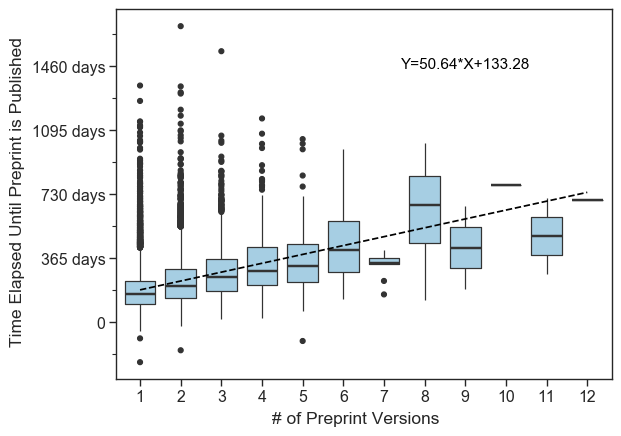

<ggplot: (8780005206606)>


In [14]:
g = (
    p9.ggplot(
        published_date_distances,
        p9.aes(x="factor(version_count)", y="time_to_published"),
    )
    + p9.geom_boxplot(fill="#a6cee3")
    + p9.geom_line(
        mapping=p9.aes(x="version_count", y="time_to_published"),
        stat="smooth",
        method="lm",
        linetype="dashed",
        se=False,
        alpha=1,
        size=0.7,
        inherit_aes=False,
    )
    + p9.scale_y_timedelta(labels=timedelta_format("d"))
    + p9.annotate(
        "text",
        x=9,
        y=timedelta(days=1470),
        label=f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    )
    + p9.labs(x="# of Preprint Versions", y="Time Elapsed Until Preprint is Published")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=1.3)
)
g.save("output/version_count_vs_publication_time_rerun.svg", dpi=500)
g.save("output/version_count_vs_publication_time_rerun.png", dpi=500)
print(g)

# Construct Scatter Plot of Date vs Document Distances

Preprints are delayed on an average of 17 days as changes are demanded from the peer-review process. This section regresses a preprint's document distance against the time it takes to have a preprint published. A scatter and square bin plot are generated below.

In [15]:
# Get smoothed linear regression line
# Was Performed with Negative time added
x = published_date_distances.doc_distances.values.tolist()

y = published_date_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=42.953267908752096, intercept=168.83192779134873, rvalue=0.19787134521927435, pvalue=3.0946146180792276e-154, stderr=1.607353479746572, intercept_stderr=1.791811935402129)


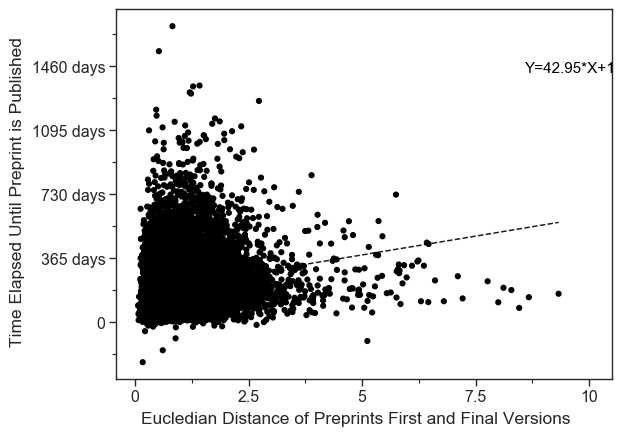

<ggplot: (8779710746239)>


In [16]:
g = (
    p9.ggplot(
        published_date_distances, p9.aes(y="time_to_published", x="doc_distances")
    )
    + p9.geom_point()
    + p9.geom_line(
        stat="smooth", method="lm", linetype="dashed", se=False, alpha=0.9, size=0.6
    )
    + p9.scale_y_timedelta(labels=timedelta_format("d"))
    + p9.annotate(
        "text",
        x=10,
        y=timedelta(days=1450),
        label=f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    )
    + p9.labs(
        x="Eucledian Distance of Preprints First and Final Versions",
        y="Time Elapsed Until Preprint is Published",
    )
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=1.3)
)
print(g)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/article_distance_vs_publication_time_rerun.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/article_distance_vs_publication_time_rerun.png


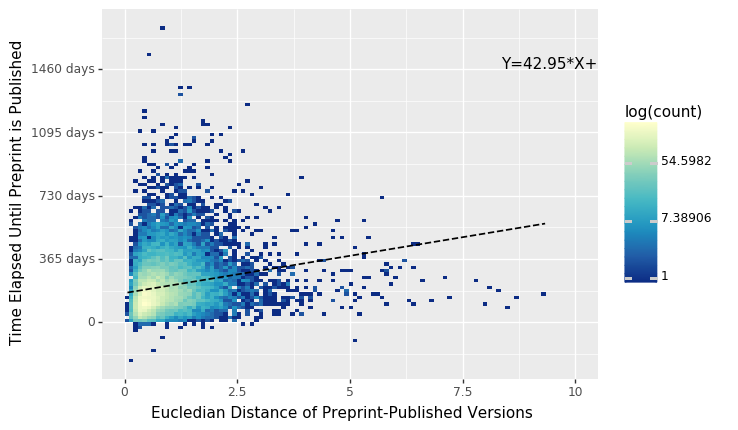

<ggplot: (-9223363256851227655)>


In [17]:
g = (
    p9.ggplot(
        published_date_distances, p9.aes(x="doc_distances", y="time_to_published")
    )
    + p9.geom_bin2d(bins=100)
    + p9.scale_fill_distiller(
        trans="log",
        direction=-1,
        type="seq",
        palette="YlGnBu",
        name="log(count)",
        labels=log_format(base=10),
    )
    + p9.geom_line(
        stat="smooth", method="lm", linetype="dashed", se=False, alpha=1, size=0.7
    )
    + p9.scale_y_timedelta(labels=timedelta_format("d"))
    + p9.annotate(
        "text",
        x=10,
        y=timedelta(days=1490),
        label=f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    )
    + p9.labs(
        x="Eucledian Distance of Preprint-Published Versions",
        y="Time Elapsed Until Preprint is Published",
        legend="log(count)",
    )
)
g.save("output/article_distance_vs_publication_time_rerun.svg", dpi=250)
g.save("output/article_distance_vs_publication_time_rerun.png", dpi=250)
print(g)

# Contextualize Document Distances

The goal here is to understand what a unit of distance represents for two document embeddings. It is already established that low distances can indicate similar documents, but question remains how does a unit of distances relate to time taken to get published? To answer this question I randomly sampled two preprints from the following groups: same journal, same preprint category and conglomeration of all bioRxiv preprints. Sampled preprints have their distance measured and I report the average distance of each group.

In [18]:
def random_combination(iterable, r, size=100, seed=100):
    "Random selection from itertools.combinations(iterable, r)"
    random.seed(seed)

    pool = tuple(iterable)
    n = len(pool)

    indices = [sorted(random.sample(range(n), r)) for elem in range(size)]

    for i in indices:
        yield (pool[i[0]], pool[i[1]])


def article_distances(
    iterable, embed_df, combination_size=2, sample_size=100, seed=100
):
    article_pair_generator = random_combination(
        iterable, combination_size, sample_size, seed
    )

    paper_one, paper_two = zip(*article_pair_generator)
    temp_index = embed_df.set_index("document")

    return np.diag(
        cdist(
            temp_index.loc[list(paper_one)].values,
            temp_index.loc[list(paper_two)].values,
            "euclidean",
        )
    )

In [19]:
# Randomly sample two papers from the same journal 1000 times - plos one
plos_one_distances = article_distances(
    biorxiv_journal_df.query("journal=='PLoS_Genet'").document.tolist(),
    biorxiv_embed_df,
    2,
    1000,
)

print(
    f"Genetics Stats Mean: {np.mean(plos_one_distances):.3f}, "
    f"Std: {np.std(plos_one_distances):.3f}"
)

Genetics Stats Mean: 4.599, Std: 1.149


In [20]:
# Randomly sample two papers from the same field category 1000 times - bioinformatics
bioinformatic_distances = article_distances(
    biorxiv_journal_df.query("category == 'bioinformatics'")
    .query(f"document in {biorxiv_embed_df.document.tolist()}")
    .document.tolist(),
    biorxiv_embed_df,
    2,
    1000,
)

print(
    f"Bioinformatics Stats Mean: {np.mean(bioinformatic_distances):.3f}, "
    f"Std: {np.std(bioinformatic_distances):.3f}"
)

Bioinformatics Stats Mean: 4.470, Std: 0.939


In [21]:
# Randomly sample two papers from the entire bioRxiv corpus 1000 times
biorxiv_distances = article_distances(
    biorxiv_journal_df.query(
        f"document in {biorxiv_embed_df.document.tolist()}"
    ).document.tolist(),
    biorxiv_embed_df,
    2,
    1000,
)

print(
    f"Biorxiv Stats Mean: {np.mean(biorxiv_distances):.3f}, "
    f"Std: {np.std(biorxiv_distances):.3f}"
)

Biorxiv Stats Mean: 5.343, Std: 1.109


Take home results:
    1. It takes approximately 51 days for a new preprint version to be posted onto bioRxiv.
    2. Making peer review changes takes on average 17 days to make for given preprints.
    3. A distance unit reflects about an 18% ((6.210-5.068)/6.210) change of a preprints textual content